# 다양한 OCR모델 비교하기

Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR


In [1]:
import os
import glob
import keras_ocr
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
from PIL import Image

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


In [2]:
def createFolder(path_dir):
    try:
        if not os.path.exists(path_dir):
            os.makedirs(path_dir)
    except OSError:
        print ('Error: Creating directory. ' +  path_dir)


# Step1. 검증용 데이터셋 준비

- 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미침 
- 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.


In [3]:
filenames = glob.glob('./sample/*.jpg')
images = [keras_ocr.tools.read(path) for path in filenames]


# Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)

- 모듈이 출력한 결과를 모음


## keras-ocr


In [4]:
# keras-ocr
pipeline = keras_ocr.pipeline.Pipeline()
prediction_groups = [pipeline.recognize([path]) for path in filenames]


Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [5]:
print(type(prediction_groups))
print(len(prediction_groups))

print(type(prediction_groups[0]))
print(len(prediction_groups[0]))

print(type(prediction_groups[0][0]))
print(len(prediction_groups[0][0]))

print(type(prediction_groups[0][0][0]))
print(len(prediction_groups[0][0][0]))

print(type(prediction_groups[0][0][0][0]))
print(len(prediction_groups[0][0][0][0]))

print(type(prediction_groups[0][0][0][1]))
print(len(prediction_groups[0][0][0][1]))


<class 'list'>
4
<class 'list'>
1
<class 'list'>
54
<class 'tuple'>
2
<class 'str'>
3
<class 'numpy.ndarray'>
4


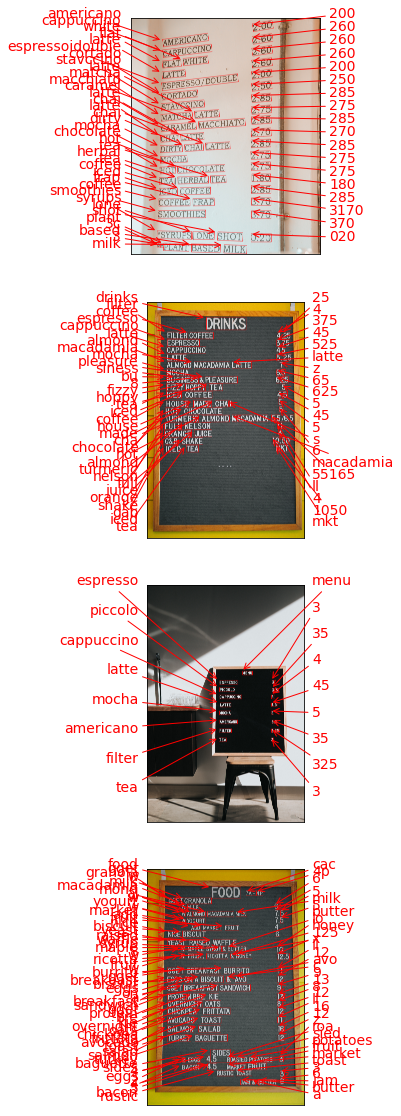

In [6]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0], ax=ax)


## tesseract


In [7]:
# tesseract

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.


# crop_word_regions() : 입력 이미지에서 문자 영역 검출 후, 검출된 문자 영역을 crop한 이미지로 출력
# pytesseract() : pytesseract로 영역 검출(바운딩 박스; left, top, width, height) 
# image_to_data() : 바운딩 박스를 사용해 이미지의 문자 영역들을 잘라(crop)서 저장
# (주의) 위 코드에서 lang='kor' 로 바꾸면 에러가 발생, 테서랙트의 언어팩을 설치해야 함
def crop_word_regions(image_path, output_path, language = 'eng', oem = 3, psm = 3):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem ' + str(oem) + r'--psm ' + str(psm)
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(image, lang=language, 
                                                config=custom_oem_psm_config, output_type=Output.DICT)
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            # print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


In [8]:
# 테서랙트로 잘린 이미지에서 단어 인식하기
# image_to_string() : 검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 출력
def recognize_images(cropped_image_path_list, oem = 3, psm = 7, language = 'eng'):
    text_recog = []
    custom_oem_psm_config = r'--oem ' + str(oem) + r' --psm ' + str(psm)
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        # 한국어라면 lang='kor'
        recognized_data = pytesseract.image_to_string(image, lang=language, 
                                                      config=custom_oem_psm_config, output_type=Output.DICT)
        text_recog.append(recognized_data['text'])
        # print(recognized_data['text'])
    print("Done")
    return text_recog

In [9]:
work_dir = './detec_img'
path_file = filenames[0]
cropped_image_path_list = crop_word_regions(path_file, work_dir)

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
text_recog = recognize_images(cropped_image_path_list)


Done


In [10]:
print(text_recog)

['\x0c', '; : ) :\n\x0c', '275 i i\n\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '| e |\n\x0c', 'ee | | |\n\x0c', '()T\n\x0c', 'CHOCOLATE\n\x0c', 'EA|HERBAL\n\x0c', 'TEA\n\x0c', 'ICED\n\x0c', 'COFFEE\n\x0c', 'OFFER\n\x0c', 'FRAP\n\x0c', '“SMOOTHIES\n\x0c', '\x0c', 'Aaa ae\n\x0c', '"OYRUPS | ONE\n\x0c', 'SHOW\n\x0c', '() 20\n\x0c', '**PLANT\n\x0c', 'BASED\n\x0c', 'MILK\n\x0c', 'tT\n\x0c']


In [12]:
for text in text_recog:
    print(text)



; : ) :

275 i i







| e |

ee | | |

()T

CHOCOLATE

EA|HERBAL

TEA

ICED

COFFEE

OFFER

FRAP

“SMOOTHIES


Aaa ae

"OYRUPS | ONE

SHOW

() 20

**PLANT

BASED

MILK

tT



# Step3. 테스트 결과 정리

- 모듈들마다 출력 형태가 다름, 분석을 위해 결과를 일목요연하게 정리
- 시각화


## keras-ocr

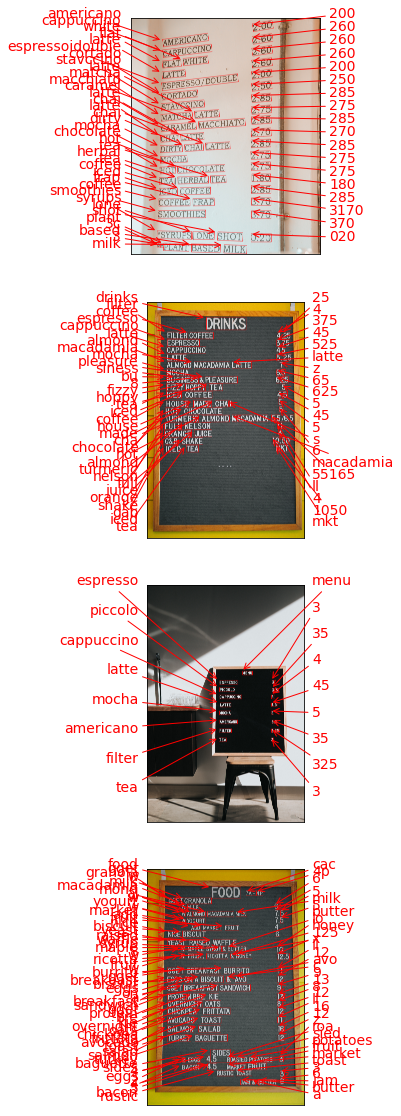

In [6]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0], ax=ax)


## tesseract

In [12]:
for text in text_recog:
    print(text)



; : ) :

275 i i







| e |

ee | | |

()T

CHOCOLATE

EA|HERBAL

TEA

ICED

COFFEE

OFFER

FRAP

“SMOOTHIES


Aaa ae

"OYRUPS | ONE

SHOW

() 20

**PLANT

BASED

MILK

tT



# Step4. 결과 분석과 결론 제시

- 구현하고자 하는 서비스의 목적과 내용을 먼저 정리
- OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시
- 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.


- keras-ocr가 더 정확하게 추출
- keras-ocr 소수점 누락됨

- tesseract 잘 못 추출된 경우가 많고 빈공간에 대한 추출이 심함
